In [1]:
import os
import sys
from typing import (
    List,
    Dict,
    Tuple,
    Union,
)
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

%matplotlib inline

In [2]:
sys.path.append("../../../lib")

In [3]:
%load_ext autoreload
%autoreload 2

from util_opencv.image import (
    validate_image,
    get_image,
    save_image,
    get_image_dimensions,
    resize_image,
    show_image,
    show_image_opencv,
    resize_and_save_images,
    convert_bgr_to_rgb,
    pack_images_as_rgb_from_directory,
)
from util_numpy import (
    get_cosine_similarity,
    save,
    load,
)

# Resize images

---

In [4]:
from keras.models import (
    Model, 
    Sequential
)
import tensorflow as tf
from tensorflow.keras.applications import (
#    ResNet152V2,
    ResNet50,
)
from tensorflow.keras.applications.resnet50 import (
     preprocess_input, 
     decode_predictions
 )

from util_tf.resnet50 import (
    preprocess_rgb_image_for_resnet,
    ResNet50Helper,
)

# Classification by ResNet50

* [ResNet50](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50)
* [tf.keras.applications.resnet50.preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/preprocess_input)

> ```
> tf.keras.applications.resnet50.preprocess_input(
>    x, data_format=None
>)
> """
> Args:
>     x:  
>         A floating point numpy.array or a tf.Tensor, 3D or 4D with 3 color channels, 
>         with values in the range [0, 255]. The preprocessed data are written over 
>         the input data if the data types are compatible. To avoid this behaviour, 
>         numpy.copy(x) can be used.  
> Returns: Preprocessed numpy.array or a tf.Tensor with type float32.
> """
> ```

* [tf.keras.applications.resnet50.decode_predictions](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/decode_predictions)

> Returns: A list of lists of top class prediction tuples ```(class_name, class_description, score)```. One list of tuples per sample in batch input.



* [Usage examples for image classification models - Classify ImageNet classes with ResNet50](https://keras.io/api/applications/#usage-examples-for-image-classification-models)

> ```
> from tensorflow.keras.applications.resnet50 import ResNet50
> from tensorflow.keras.preprocessing import image
> from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
> import numpy as np
> 
> model = ResNet50(weights='imagenet')
> 
> img_path = 'elephant.jpg'
> img = image.load_img(img_path, target_size=(224, 224))
> x = image.img_to_array(img)
> x = np.expand_dims(x, axis=0)
> x = preprocess_input(x)
> 
> preds = model.predict(x)
> # decode the results into a list of tuples (class, description, probability)
> # (one such list for each sample in the batch)
> print('Predicted:', decode_predictions(preds, top=3)[0])
> # Predicted: [(u'n02504013', u'Indian_elephant', 0.82658225), (u'n01871265', u'tusker', 0.1122357), (u'n02504458', u'African_elephant', 0.061040461)]
> ```

## Model

In [5]:
resnet: ResNet50Helper = ResNet50Helper()
model: Model = resnet.model

In [6]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

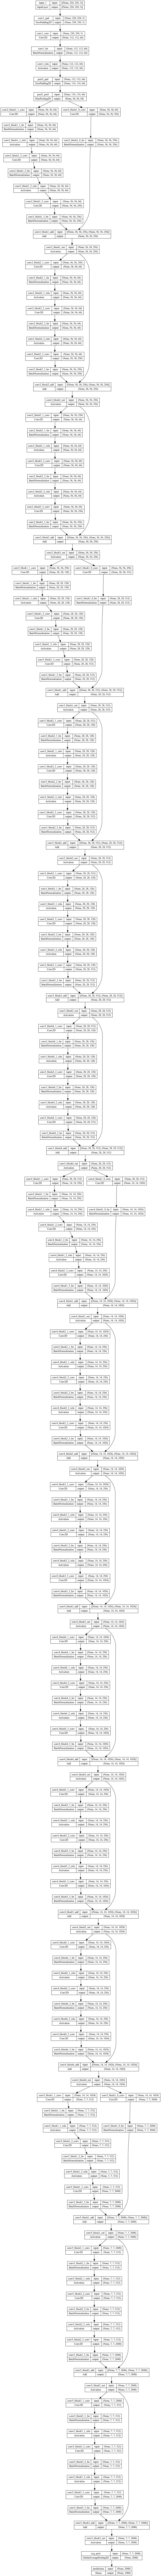

In [7]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True
)

## Image to Predict

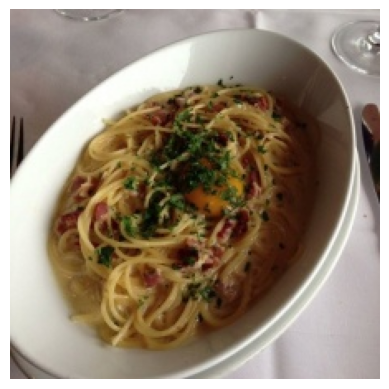

In [8]:
image = get_image(path="../data/resized/00004.jpg")
show_image(image)

### Preprocess 

Preprocess image as the input to ResNet.

1. BGR (OpenCV default in-memory format) to RGB.
2. Preprocess with resnet.preprocess_input which expects images in RGB.


### Predict

In [9]:
# image is in BGR loaded by OpenCV imread
resnet.predict(images=image, top=3, bgr_to_rgb=True)

2023-01-22 18:41:45.626489: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 0s 409ms/step


[[('n07831146', 'carbonara', 0.9956995),
  ('n07579787', 'plate', 0.0025090328),
  ('n07716906', 'spaghetti_squash', 0.000849533)]]

## Batch Predictions

### Load Images as RGB of shape (N, 224, 224, 3)

In [10]:
images: np.ndarray
names: List[str]
images, names = pack_images_as_rgb_from_directory(
    path_to_source="../data/resized",
    pattern="*.jpg",
)
images.shape

(4031, 224, 224, 3)

In [11]:
save(array=images, path_to_file="../data/result/resized_images.npy")

'../data/result/resized_images.npy'

In [12]:
step: int = 10
predictions = resnet.predict(images[::step,])   # Image is RGB as converted by pack_images_as_rgb_from_directory
for name, pred in zip(names[::step], predictions):
    print(f"{name}:[{pred}]")

13/13 [==============================] - 11s 805ms/step
00000.jpg:[[('n04263257', 'soup_bowl', 0.8761964), ('n07831146', 'carbonara', 0.06766038), ('n07584110', 'consomme', 0.022334654)]]
00010.jpg:[[('n07579787', 'plate', 0.85463375), ('n07684084', 'French_loaf', 0.034390703), ('n07697537', 'hotdog', 0.025767494)]]
00020.jpg:[[('n02776631', 'bakery', 0.7261273), ('n07875152', 'potpie', 0.12473633), ('n07579787', 'plate', 0.048246276)]]
00030.jpg:[[('n04263257', 'soup_bowl', 0.76870006), ('n07584110', 'consomme', 0.11603344), ('n07930864', 'cup', 0.014950149)]]
00040.jpg:[[('n02281406', 'sulphur_butterfly', 0.55624086), ('n07716906', 'spaghetti_squash', 0.16412072), ('n07717556', 'butternut_squash', 0.06013844)]]
00050.jpg:[[('n04111531', 'rotisserie', 0.34454888), ('n07873807', 'pizza', 0.26641464), ('n04270147', 'spatula', 0.19411193)]]
00060.jpg:[[('n07584110', 'consomme', 0.99782664), ('n07920052', 'espresso', 0.0018759068), ('n07836838', 'chocolate_sauce', 0.00013848825)]]
00070.j

---

# Feature Extraction from ResNet50 

In [13]:
feature_extractor: Model = resnet.feature_extractor

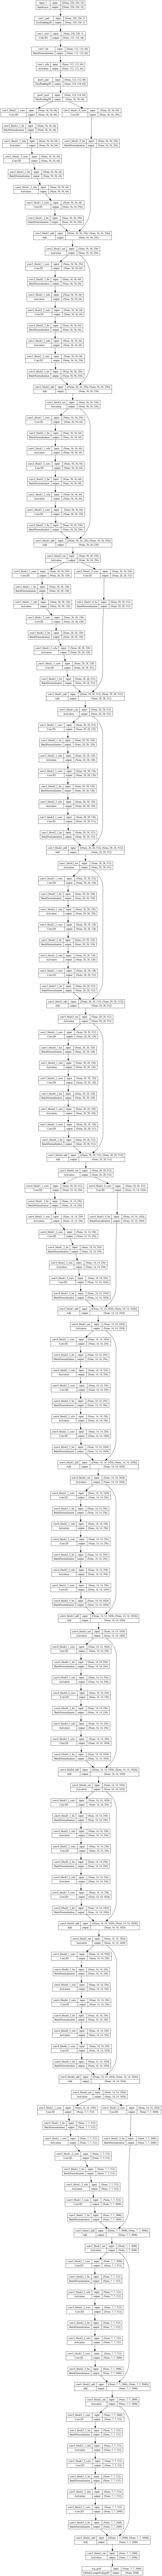

In [14]:
tf.keras.utils.plot_model(
    feature_extractor,
    show_shapes=True,
    show_layer_names=True
)

In [21]:
# Image is in BGR as loaded by OpenCV imread
image_dog_01: np.ndarray = get_image(path="../data/resized/01377.jpg")
embedding_dog_01: np.ndarray = resnet.embed(images=image_dog_01, bgr_to_rgb=True)
embedding_dog_01.shape

1/1 [==============================] - 0s 54ms/step


(1, 2048)

In [22]:
resnet.predict(images=image_dog_01, top=3, bgr_to_rgb=True)

1/1 [==============================] - 0s 52ms/step


[[('n02093428', 'American_Staffordshire_terrier', 0.6654879),
  ('n02093256', 'Staffordshire_bullterrier', 0.29221672),
  ('n02099712', 'Labrador_retriever', 0.022703243)]]

In [23]:
image_dog_02: np.ndarray = get_image(path="../data/resized/01381.jpg")
embedding_dog_02: np.ndarray = resnet.embed(images=image_dog_02, bgr_to_rgb=True)
embedding_dog_02.shape

1/1 [==============================] - 0s 51ms/step


(1, 2048)

In [24]:
resnet.predict(images=image_dog_02, top=3, bgr_to_rgb=True)

1/1 [==============================] - 0s 55ms/step


[[('n02111500', 'Great_Pyrenees', 0.7186919),
  ('n02104029', 'kuvasz', 0.2062113),
  ('n02099601', 'golden_retriever', 0.06403511)]]

In [25]:
# Image is in BGR as loaded by OpenCV imread
image_cat_01: np.ndarray = get_image(path="../data/resized/01399.jpg")
embedding_cat_01: np.ndarray = resnet.embed(images=image_cat_01, bgr_to_rgb=True)
embedding_cat_01.shape

1/1 [==============================] - 0s 50ms/step


(1, 2048)

In [26]:
resnet.predict(images=image_cat_01, top=3, bgr_to_rgb=True)

1/1 [==============================] - 0s 54ms/step


[[('n02124075', 'Egyptian_cat', 0.59315807),
  ('n02123045', 'tabby', 0.37031692),
  ('n02123159', 'tiger_cat', 0.009501291)]]

# Similarities

In [30]:
get_cosine_similarity(x=embedding_dog_01, y=embedding_dog_02)

array([[0.54807675]], dtype=float32)

In [29]:
get_cosine_similarity(x=embedding_dog_01, y=embedding_cat_01)

array([[0.32560736]], dtype=float32)

In [31]:
get_cosine_similarity(x=embedding_dog_02, y=embedding_cat_01)

array([[0.25182614]], dtype=float32)